# Smart UPI Transaction Risk Assessment Using Machine Learning



In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, auc)

np.random.seed(42)


In [16]:

N = 10000
fraud_ratio = 0.07 


user_ids = np.random.choice([f'user_{i}' for i in range(2000)], size=N)

amount = np.round(np.random.lognormal(mean=6, sigma=1.2, size=N), 2)  # wide range


txn_types = np.random.choice(['P2P', 'merchant', 'recharge', 'bill_payment'], size=N, p=[0.35, 0.45, 0.10, 0.10])


device = np.random.choice(['Android', 'iOS', 'Web'], size=N, p=[0.75, 0.20, 0.05])


merchants = np.random.choice(['grocery', 'utilities', 'electronics', 'entertainment', 'travel', 'others'], size=N,
                             p=[0.25, 0.15, 0.20, 0.10, 0.05, 0.25])


hour = np.random.randint(0, 24, size=N)

'transactions_last_24h' in locals()

transactions_last_24h = np.random.poisson(0.5, size=N)


is_foreign = np.random.choice([0,1], size=N, p=[0.98, 0.02])


base_risk = (amount / (amount.mean()+1)) * 0.3
base_risk += (transactions_last_24h > 3).astype(int) * 0.5
base_risk += (is_foreign==1).astype(int) * 1.0
base_risk += ((txn_types=='merchant') & (merchants=='electronics')).astype(int) * 0.2
base_risk += ((hour < 6) | (hour > 23)).astype(int) * 0.15


base_risk = (base_risk - base_risk.min()) / (base_risk.max() - base_risk.min())


prob_fraud = 0.02 + 0.5 * base_risk  # baseline 2%, scaled by risk


scaling = fraud_ratio / prob_fraud.mean()
prob_fraud = np.clip(prob_fraud * scaling, 0, 0.95)

is_fraud = np.random.binomial(1, prob_fraud)

df = pd.DataFrame({
    'user_id': user_ids,
    'transaction_amount': amount,
    'transaction_type': txn_types,
    'device_type': device,
    'merchant_category': merchants,
    'hour': hour,
    'transactions_last_24h': transactions_last_24h,
    'is_foreign': is_foreign,
    'is_fraud': is_fraud
})


print('Rows:', len(df))
print('Fraud ratio:', df['is_fraud'].mean())
df.head()

Rows: 10000
Fraud ratio: 0.0715


,user_id,transaction_amount,transaction_type,device_type,merchant_category,hour,transactions_last_24h,is_foreign,is_fraud
0,user_1126,101.35,P2P,Android,others,16,0,0,0
1,user_1459,13.37,merchant,Android,grocery,23,0,0,1
2,user_860,152.74,P2P,iOS,entertainment,8,1,0,0
3,user_1294,1271.62,P2P,Android,electronics,5,1,0,0
4,user_1130,750.20,P2P,Android,others,17,0,0,0


In [17]:

X = df.drop(columns=['is_fraud', 'user_id'])
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

numeric_features = ['transaction_amount', 'hour', 'transactions_last_24h']
cat_features = ['transaction_type', 'device_type', 'merchant_category', 'is_foreign']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, cat_features)
])

# Pipelines for the two models
lr_pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
rf_pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

Train size: 7500 Test size: 2500


In [18]:

lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
print('Training completed')

Training completed


In [19]:
# Predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:,1]

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:,1]


def evaluate_model(y_true, y_pred, y_proba, model_name):
    print('---', model_name, '---')
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)
    roc_auc = roc_auc_score(y_true, y_proba)
    print('ROC-AUC:', round(roc_auc,4))
    return roc_auc, cm

roc_lr, cm_lr = evaluate_model(y_test, y_pred_lr, y_proba_lr, 'Logistic Regression')
roc_rf, cm_rf = evaluate_model(y_test, y_pred_rf, y_proba_rf, 'Random Forest')


--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0     0.9308    0.9966    0.9625      2321
           1     0.4667    0.0391    0.0722       179

    accuracy                         0.9280      2500
   macro avg     0.6987    0.5178    0.5174      2500
weighted avg     0.8976    0.9280    0.8988      2500

Confusion Matrix:
 [[2313    8]
 [ 172    7]]
ROC-AUC: 0.6771
--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0     0.9315    0.9836    0.9568      2321
           1     0.2245    0.0615    0.0965       179

    accuracy                         0.9176      2500
   macro avg     0.5780    0.5225    0.5267      2500
weighted avg     0.8808    0.9176    0.8952      2500

Confusion Matrix:
 [[2283   38]
 [ 168   11]]
ROC-AUC: 0.6442


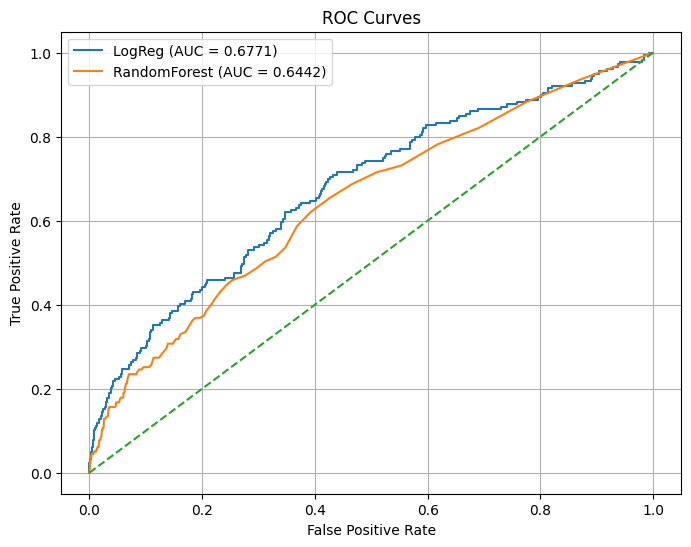

In [20]:
# Plot ROC curves for both models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {auc(fpr_lr, tpr_lr):.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc(fpr_rf, tpr_rf):.4f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


In [21]:

results = X_test.copy()
results['actual_is_fraud'] = y_test.values
results['lr_risk_score'] = y_proba_lr
results['rf_risk_score'] = y_proba_rf


results_sorted = results.sort_values('rf_risk_score', ascending=False).head(10)
results_sorted[['transaction_amount','transaction_type','merchant_category','lr_risk_score','rf_risk_score','actual_is_fraud']]


,transaction_amount,transaction_type,merchant_category,lr_risk_score,rf_risk_score,actual_is_fraud
8443,2103.75,merchant,grocery,0.100178,0.765,0
7306,23232.84,recharge,grocery,0.963648,0.745,1
4279,10280.40,merchant,others,0.497291,0.740,1
9871,154.52,merchant,others,0.214916,0.720,0
2926,9899.96,recharge,grocery,0.431006,0.715,1
1125,13383.91,merchant,others,0.730267,0.710,1
3701,404.30,merchant,electronics,0.075868,0.695,0
9295,1871.79,merchant,electronics,0.104795,0.690,0
2859,27857.74,recharge,grocery,0.989909,0.685,1
5547,268.70,merchant,utilities,0.061060,0.680,1
